### Если вы хотите выполнять эту домашку на своём компе, то вам придётся даунгрейднуть gym. Вот код который должен выполниться сам, но возможно ещё что-то вам поломает.

### Или просто делайте её в гугл колабе, там всё само поставится и будет ок, но в гугл колабе не работает рендер (ImportError: Library "GLU" not found.)


In [1]:
!pip install wheel==0.38.4
!pip install setuptools==66
!pip install gym==0.21.0
!pip install pyglet==1.5.27
#тут я установил библиотеки нужной версии (долго искал как установить надо)

In [17]:
import gym#в этой библиотеки куча наборов сред, в этой работате мы воспользовались "CartPole-v0"
import numpy as np
import matplotlib.pyplot as plt #удобная библиотека, с помощью которой можно выводить состояния на экран
import pyglet
%matplotlib inline #с этой штукой наши графики отображены не в отдельном окне, а тут
from IPython.display import clear_output #а эта штука нужна для отображения каждого шага в окнах. то есть сначала нужно стереть прошлый шаг, чтобы вывести текущий

from math import * #звуздочка нужна для того, чтобы импортировать все сразу, а не импортировать по отдельности каждое
import time #тайм
time.clock = time.time

## Seminar: Monte-carlo tree search

In this seminar, we'll implement a vanilla MCTS planning and use it to solve some Gym envs.

But before we do that, we first need to modify gym env to allow saving and loading game states to facilitate backtracking.

In [18]:
from gym.core import Wrapper #класс Wrapperэту штуку часто используют, когда требуется модифицировать или настроить поведение игровой среды без изменения её исходного кода
from pickle import dumps,loads #как я и написал внизу dumps преобразует данные в линейную форму, которую можно удобно сохранить, а loads переделывает обратно
from collections import namedtuple #штука которой удобно пользоваться, как например в следующей строчке

ActionResult = namedtuple("action_result",("snapshot","observation","reward","is_done","info")) #в принципе можно хранить данные и по-другому, но так удобнее и красивее. эта команда создает тип данных ActionResult, у которого есть поля описанные в строках

class WithSnapshots(Wrapper): #созданием этого класса мы хотим дополнить функции класса Wrapper
    """
    Creates a wrapper that supports saving and loading environemnt states.
    Required for planning algorithms.

    This class will have access to the core environment as self.env, e.g.:
    - self.env.reset()           #reset original env
    - self.env.ale.cloneState()  #make snapshot for atari. load with .restoreState()
    - ...

    You can also use reset, step and render directly for convenience.
    - s, r, done, _ = self.step(action)   #step, same as self.env.step(action)
    - self.render(close=True)             #close window, same as self.env.render(close=True)
    """

        
    def get_snapshot(self): #функция получения состояния
        """
        :returns: environment state that can be loaded with load_snapshot 
        Snapshots guarantee same env behaviour each time they are loaded.
        
        Warning! Snapshots can be arbitrary things (strings, integers, json, tuples)
        Don't count on them being pickle strings when implementing MCTS.
        
        Developer Note: Make sure the object you return will not be affected by 
        anything that happens to the environment after it's saved.
        You shouldn't, for example, return self.env. 
        In case of doubt, use pickle.dumps or deepcopy.
        
        """
        self.close() #закрываем всплывающие окна для того, чтобы завершить отображение информации.
        return dumps(self.env) #чтобы на наш возращаемый объект ничего не повлияло лучше вернуть dumps(self.env). эта функция сериализирует наши данные. короче классная штука, которая сохраняет данные в удобной форме, которую можно будет переделать (ну как раз с помощью команды loads)
    
    def load_snapshot(self,snapshot): #эта функция нужна для того, чтобы сделать снимок и загрузить его в качестве состояния среды, а также предотвратить возможную не запись среды 
        """
        Loads snapshot as current env state.
        Should not change snapshot inplace (in case of doubt, deepcopy
        """
        
        assert not hasattr(self,"_monitor") or hasattr(self.env,"_monitor"), "can't backtrack while recording" #я разобрался что делает эта штука. если выражение not hasattr(self,"_monitor") или hasattr(self.env,"_monitor") правда то все норм, а если нет то вызывается ошибка ассерта. по факту эта строка гарантирует что наши данные сохранились

        self.close() #закрываем всплывающие окна для того, чтобы завершить отображение информации.
        self.env = loads(snapshot) #загружает снимок в текущее состояние среды
    
    def get_result(self,snapshot,action):
        """
        A convenience function that 
        - loads snapshot, 
        - commits action via self.step,
        - and takes snapshot again :)
        
        :returns: next snapshot, next_observation, reward, is_done, info
        
        Basically it returns next snapshot and everything that env.step would have returned.
        """
        state = self.load_snapshot(snapshot) #загружает состояние окружения из сохраненного снимка
        s, r, done, i = self.step(action) #тут мы делаем шаг в котором получаем наблюдения ситуации (в переменную s), также награду (в переменную r), получилось ли сделать (в переменную done), а также дополнительную информацию (в переменную i)
        nextsn = self.get_snapshot() #в эту переменную записывает текущий снимок состояния окружения
        
        return ActionResult(nextsn, s, r, done, i) #возвращает данные в удобном формате, который был описан ранее (в начале)

### try out snapshots (2 pts):


In [19]:
env = WithSnapshots(gym.make("CartPole-v0"))#окей, я понял, что тут он создает среду, которая похожа на маятник на тележке (удобная фигня из библиотеки gym) и записывает ее в эту переменную новым классом, который мы описали ранее. ну в смысле добавили новые функции к классу Wrapper
env.reset()#сбрасывает среду в начальное состояние

n_actions = env.action_space.n #подсчитывает количество возможных действий в этой среде и присваивает этой переменной

initial_state:


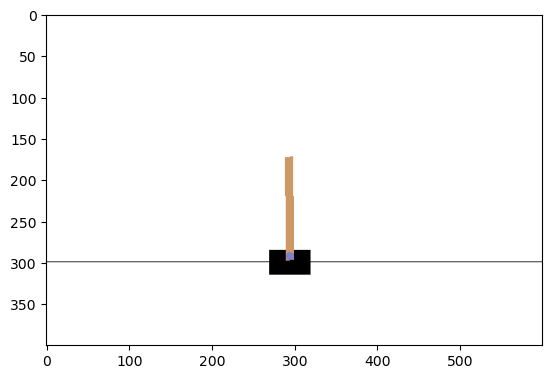

In [20]:
print("initial_state:")

plt.imshow(env.render('rgb_array')) #эта стркоа показывает наше текущее состояние в среде env, тк как наша среда была сброшена, то это самое первое состояние которое запрогано в этой игре

snap0 = env.get_snapshot() #мы получаем первый снимок среды

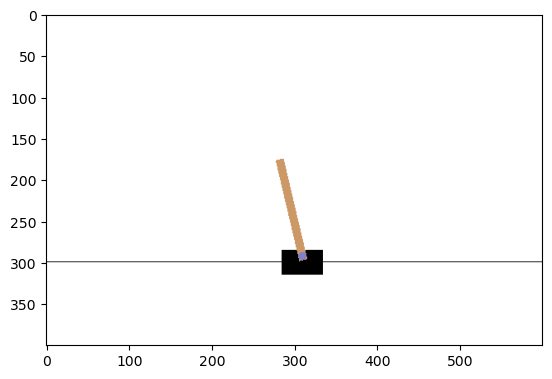

In [21]:
while True:
    is_done = env.step(env.action_space.sample())[2] #короче мы предпринимаем рандомные шаги и смотрим че происходит, а нашу информацию записываем в эту переменную
    if is_done: #тк это первые шаги с помощью которых мы будем потом учить нашу машинку, то мы дожидаемся пока он не проиграет, а дальше будем учить ее по информации, которую она получила
        print("Whoops! We died!")
        break
        
print("final state:")
clear_output(True)
plt.imshow(env.render('rgb_array')) #просто выводим последний шаг
plt.show()



After loading snapshot


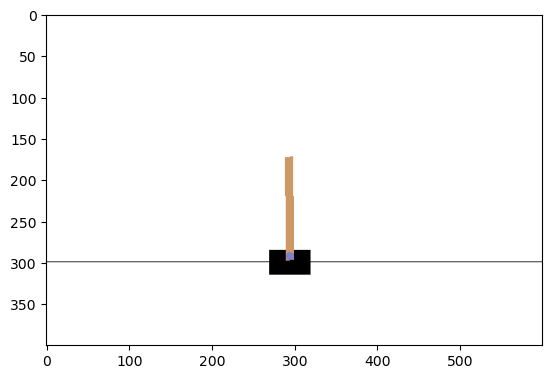

In [22]:

env.load_snapshot(snap0) #загружаем состояние среды, которое получили в прошлом блоке

print("\n\nAfter loading snapshot") #ну я думаю объяснять не надо
plt.imshow(env.render('rgb_array')) #получается мы показали состояние среды после загрузки конечного состояния
plt.show()

In [23]:

res = env.get_result(snap0,env.action_space.sample()) #здесь мы получаем результат об одном рандомном действии

snap1, observation, reward = res[:3] #я так понял что мы развертываем результат и в переменную snap1 кидает снимок после выполнения, в observation - состояние, а в reward - награду полученную за этот шаг

res2 = env.get_result(snap1,env.action_space.sample()) #тут мы делаем еще действие и записываем его в res2

# MCTS: Monte-Carlo tree search

In this section, we'll implement the vanilla MCTS algorithm with UCB1-based node selection.

We will start by implementing the `Node` class - a simple class that acts like MCTS node and supports some of the MCTS algorithm steps.

This MCTS implementation makes some assumptions about the environment, you can find those _in the notes section at the end of the notebook_.

In [24]:
assert isinstance(env,WithSnapshots) #я не очень опнимаю зачем тутэта команда, потому что она просто проверяет принадлежит ли наша среда классу, который мы ей давали

In [25]:
class Node: #это то как строится сам mcts, который я не мог рассказать. строим свой
    """ a tree node for MCTS """
    

    parent = None  
    value_sum = 0.  
    times_visited = 0
    #тут добавление параметов которыми владеет нод. все они названы очень понятно, поэтому я думаю, что можно не обьяснять
    
    def __init__(self,parent,action,): #эта функция инициализирует данное действие дерева
        """
        Creates and empty node with no children.
        Does so by commiting an action and recording outcome.
        
        :param parent: parent Node
        :param action: action to commit from parent Node
        
        """
        
        self.parent = parent
        self.action = action #в этой строчке и выше все понятно
        self.children = set() #тут мы устанавливаем что у нас есть (в смысле существуют) следующие разные состояния

        res = env.get_result(parent.snapshot,action) #тут мы получаем результат этого действия
        self.snapshot,self.observation,self.immediate_reward,self.is_done,_ = res #и сохраняем
        
        
    def is_leaf(self): #эта штука проверяет есть ли следующие ходы
        return len(self.children)==0 #по коду все понятно
    
    def is_root(self): #смотрит начальный ли это ход
        return self.parent is None #по коду все понятно
    
    def get_mean_value(self): #возвращает среднее значение
        return self.value_sum / self.times_visited if self.times_visited !=0 else 0 #получается сумму значений на количество посещений
    
    def ucb_score(self,scale=10,max_value=1e100): #как вы говорили это ucb. расчитываем значение вершины, чтобы понять куда идти
        """
        Computes ucb1 upper bound using current value and visit counts for node and it's parent.
        
        :param scale: Multiplies upper bound by that. From hoeffding inequality, assumes reward range to be [0,scale].
        :param max_value: a value that represents infinity (for unvisited nodes)
        
        """
        
        if self.times_visited == 0:
            return max_value #все логично, чтобы x / 0 не получить
        
        U = (2 ** 0.5) * ((log(self.parent.times_visited if not self.is_root() else 0) / self.times_visited) ** 0.5)
        #формулу такую же видел в интернете, я так понял отличается из-за scale, я не указал, что лучше иметь какой-то параметр, зависящий от среды 
        return self.get_mean_value() + scale*U
    
    
    
    def select_best_leaf(self): #рекурсивно выбирает нод с наивысшим приоритетом для расширения
        """
        Picks the leaf with highest priority to expand
        Does so by recursively picking nodes with best UCB-1 score until it reaches the leaf.
        
        """
        if self.is_leaf():
            return self
        
        children = self.children
        
        best_child = [i for i in children][np.argmax(np.array([i.ucb_score() for i in children]))]
        
        return best_child.select_best_leaf() #я не знаю, что тут объяснять. тут итак все понятно идем каждый раз в наилучший и когда приходим туда, куда уже некуда идти (self.is_leaf()). и потом возвращаем это значение по рекурсии обратно
    
    def expand(self): #сама эта функция создает все возможные следующие ходы
        """
        Expands the current node by creating all possible child nodes.
        Then returns one of those children.
        """
        
        assert not self.is_done, "can't expand from terminal state" #это нужно, чтобы не пытаться развить следующие ходы, когда итак ситуация выиграна

        for action in range(n_actions):
            self.children.add(Node(self,action)) #тут для каждого возможного действия создается дочерний узел
        
        return self.select_best_leaf() #а тут он как раз таки выбирает наилучшую вершину для него методом, который я описал ранее
    
    def rollout(self,t_max=10**4): #проигрывает игру до конца выбирая действия случайным образом и суммируя вознаграждения. короче я почитал зачем это нужно. mcts иследуеи сначала ходы умно, а потом рандомно, чтобы получать информацию от этих обоих источников
        """
        Play the game from this state to the end (done) or for t_max steps.
        
        On each step, pick action at random (hint: env.action_space.sample()).
        
        Compute sum of rewards from current state till 
        Note 1: use env.action_space.sample() for random action
        Note 2: if node is terminal (self.is_done is True), just return 0
        
        """
            
        env.load_snapshot(self.snapshot) #загружает состояние среды из сохраненного снимка текущего узла
        obs = self.observation #сохраняет текущее наблюдение из нашего узла для того, чтобы обновлять состояние на каждом шаге
        is_done = self.is_done #тут все понятно
        
        rollout_reward = 0 #будет суммировать вознаграждения в ходе проигрывания
        
        snap = self.snapshot #создает копию снимка текущего состояния
        for _ in range(t_max):
            if is_done:
                break #тут все понятно. делаем макс количество шагов t_max
            action = env.action_space.sample() #тут выбирается рандомное действие
            snap, obs, rew, is_done, _ = env.get_result(snap,action) #получается новые результаты от рандомного действия, поэтому перезаписывается вот это все. новый снимок, новое наблюдение, вознаграждение, флаг завершения (snap, obs, rew, is_done)
            rollout_reward += rew #добавляет полученное вознаграждение к общему суммарному вознаграждению за проигрывание

        return rollout_reward #о нет, его возвращает
    
    def propagate(self,child_value): #рекурсивное обновление значения данных узлов на основе дочерних
        """
        Uses child value (sum of rewards) to update parents recursively.
        """
        my_value = self.immediate_reward + child_value #нуну подсчитывается значение. складывается сумма, подсчитанная в текущем узле вознаграждений и его дочерних.
        
        self.value_sum+=my_value #этим самым обновляется в принципе знаение этой вершины
        self.times_visited+=1 #посещение этой вершины было поэтому вот это еще одно.
        
        if not self.is_root(): #если это не корневая вершина
            self.parent.propagate(my_value) #а если нет, то тогда идем дальше по рекурсии
        
    def safe_delete(self):#ну да тут написано, что это безопасное удаление для предотвращения утечки памяти (в некоторых версиях питона), но теперь пон, что такое есть
        """safe delete to prevent memory leak in some python versions"""
        del self.parent
        for child in self.children:
            child.safe_delete()#тут все мега очевидно
            del child

In [26]:
class Root(Node):#окей я понял, что есть специальный узел, который является корнем дерева и используется для начала планирования и поиска оптимальных действий в среде
    def __init__(self,snapshot,observation):#инициализирует корень
        """
        creates special node that acts like tree root
        :snapshot: snapshot (from env.get_snapshot) to start planning from
        :observation: last environment observation
        """
        
        self.parent = self.action = None
        self.children = set()#все понятно, ставит себя и объявляет детей
        

        self.snapshot = snapshot #загружает снимок
        self.observation = observation #загружает наблюдение среды
        self.immediate_reward = 0 #награда
        self.is_done=False #победа или нет
    
    @staticmethod #значит, что метод относится к самому классу и не требует создания объекта этого класса для его использования
    def from_node(node): #инициализирует новый корневой узел на основе существующего узла
        """initializes node as root"""
        root = Root(node.snapshot,node.observation) #создает новый корневой узел
        copied_fields = ["value_sum","times_visited","children","is_done"] #создается список полей, которые нужно скопировать из существующего узла в новый корневой узел
        for field in copied_fields:
            setattr(root,field,getattr(node,field)) #getattr и setattr используются для получения значения поля из существующего узла
        return root #возвращаем новый инициализированный узел из данных существубщего узла

## Main MCTS loop (4 pts)

With all we implemented, MCTS boils down to a trivial piece of code.

In [27]:
def plan_mcts(root,n_iters=10):#мы создали все нужное уже для использования mcts
    """
    builds tree with monte-carlo tree search for n_iters iterations
    :param root: tree node to plan from
    :param n_iters: how many select-expand-simulate-propagete loops to make
    """
    for _ in range(n_iters):
        node = root.select_best_leaf()#выбирает лучший нод, используя UCB
        if node.is_done:#если наш нод является конечным тоо
            node.propagate(0)#обратное распространение с нулевым вознаграждением
        else: #а иначе мы идем по этому ноду дальше (в смысле переходим к дочерним)
            bstchld = node.expand() #я знаю, ято делает эта функция. я писал к ней объяснение
            bstchld.propagate(bstchld.rollout()) #обратно рапространяет результат

## Plan and execute (3 pts)
In this section, we use the MCTS implementation to find optimal policy.

In [28]:
#тут мы создаем начальный корневой узел для алгоритма MCTS
root_observation = env.reset() #сбрасывае нашу среду
root_snapshot = env.get_snapshot() #снимок текущей сброшенной среды
root = Root(root_snapshot,root_observation) #создает корневой узел, от которого и начинает строится дерево

In [29]:
#запускаем наш алгоритм mcts, для получения результатов, чтобы потом по ним выбирать лучши ходы
plan_mcts(root,n_iters=50000)

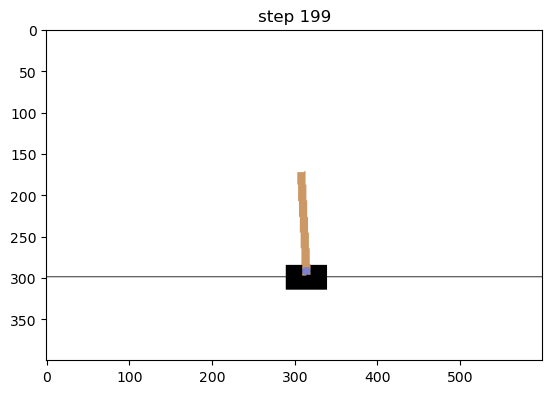

Finished with reward =  200.0


In [30]:
from gym.core import Wrapper
from IPython.display import clear_output #уже писал, этот сброс вывода, чтобы были видны действия на каждом шаге
from itertools import count #импортирование бесконечного интератора
from gym.wrappers import Monitor #предоставляет обертку для записи видео из среды

total_reward = 0 #суммарная награда
test_env = loads(root_snapshot) #создание среды, которая используется для того, чтобы показывать че происходит

for i in count():
    
    best_child = [i for i in root.children][np.argmax(np.array([i.get_mean_value() for i in root.children]))] #получение лучшего дочернего узла
    
    s,r,done,_ = test_env.step(best_child.action)#далее идет шаг в сторону лучшего дочернего узла. наши переменные заменяются, ну потому что мы идем вперед
    
    #тут мы показываем результат нашего шага
    clear_output(True)#отчищаем с помощью той импортированной штуки, чтобы наши изобрадения не шли друг за другом
    plt.title("step %i"%i)
    plt.imshow(test_env.render('rgb_array'))
    plt.show()#тут все понятно, пишется шаг и выводится картинка

    total_reward += r #награда данного шага
    if done:#тут понятно, если получилось, то все кайф
        print("Finished with reward = ", total_reward)
        break
    
    for child in root.children:#тут мы отбрасываем все ненужные дочерние узлы, чтобы удалить из памяти,  и сама память не переполнялась
        if child != best_child:
            child.safe_delete()

    
    root = Root.from_node(best_child)#ну а далее нужно сказать, что наш нынешний корень это самый лучший дочерний узел
    
    root.expand() #раскрываем все дочерние узлы
    assert not root.is_leaf(), "We ran out of tree! Need more planning! Try growing tree right inside the loop."#ну и тут мы проверяем, что есть дочерние узлы для дальнейших действий
    

## Report (1 pts)

In [ ]:
короче я разобрался, как строится само дерево, и как работает сам mcts. то есть как дальше из полученных данных "обучить" машину. мне было полезно разобраться и проделать все руками. мне кажется, ято главное понять саму суть алгоритма, чтобы потом его можно было самому написать, если понадобится